# Evaluation Metrics and Scoring

In [103]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Machine learning application goals

Kadar zbiramo metriko je pomembno da imamo v mislih, kako bo ta ocena predstavila cilj na realnih podatkih. Govorimo o "business impactu". Torej vprašamo se kaj je glavni cilj, ki ga želi naš model rešiti. Včasih se izkaže, da že izbira metrike ni trivialen problem. Vprašamo se torej katera metrika v našem specifičnem "business" primeru najbolj prikaže impact modela.

## Metrics for Binary Classification

- odvisno od specifičnega problema: primer sam accuracy ne pove razlike med false positive ali false negative
    - npr. pri detekciji raka je false negative hujša napaka kot za false positive

### Kinds of errors

### Imbalanced datasets
- primer detekcije spama -> pozitiven klas je mnogo manj zastopan
    - primer 99% klass A, 1% B ... pri oceni napovedovanja bo tudi dummy classifier se odrezal dobro (primer spodaj)
- v teh primerih si torej ne moremo dosti pomagati z accuracy metriko

In [104]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

In [105]:
from sklearn.dummy import DummyClassifier # dumnmy classifier vse vzorce napove v tisti klass ki je najbolj pogost

dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)

print(f"Unique predicted labels: {np.unique(pred_most_frequent)}")
print(f"Test score: {dummy_majority.score(X_test, y_test):.2f}")

# vidimo da je metrika ni ustrezna

Unique predicted labels: [False]
Test score: 0.90


In [106]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)

print(f"Test score: {tree.score(X_test, y_test):.2f}")

Test score: 0.92


In [107]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier(strategy="stratified", random_state=42).fit(X_train, y_train) # stratified opcija je še bolj "neumna"
pred_dummy = dummy.predict(X_test)
print(f"dummy score: {dummy.score(X_test, y_test):.2f}")

logreg = LogisticRegression(C=0.1, max_iter=10000, solver="liblinear").fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print(f"logreg score: {logreg.score(X_test, y_test):.2f}")

dummy score: 0.83
logreg score: 0.98


### Confusion matrices

In [108]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)

print(f"Confusion matrix:\n{confusion}")

# 8: false negative
# 2: false positive
# napake so izven diagonale - glej slike spodaj

Confusion matrix:
[[401   2]
 [  8  39]]


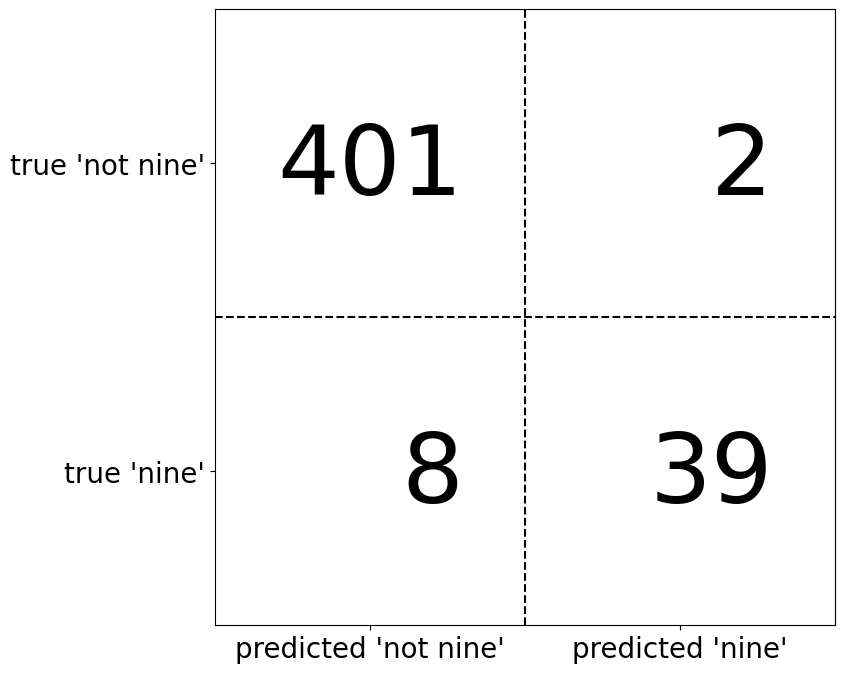

In [109]:
from helpers.plot_metrics import plot_confusion_matrix_illustration

plot_confusion_matrix_illustration()

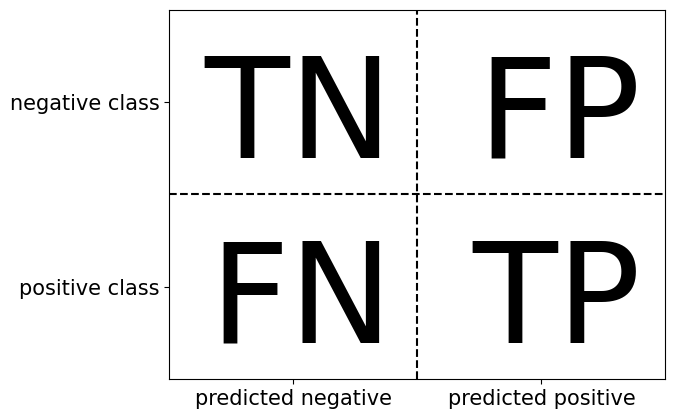

In [110]:
from helpers.plot_metrics import plot_binary_confusion_matrix

plot_binary_confusion_matrix()

In [111]:
print("Most frequent class:")
print(confusion_matrix(y_test, pred_most_frequent))
print("\nDummy model:")
print(confusion_matrix(y_test, pred_dummy))
print("\nDecision tree:")
print(confusion_matrix(y_test, pred_tree))
print("\nLogistic Regression")
print(confusion_matrix(y_test, pred_logreg))

Most frequent class:
[[403   0]
 [ 47   0]]

Dummy model:
[[367  36]
 [ 39   8]]

Decision tree:
[[390  13]
 [ 24  23]]

Logistic Regression
[[401   2]
 [  8  39]]


**Relation to accuracy**

    
    Accuracy = TP+TN / (TP + TN + FP + FN)

`Accuracy is the number of correct predictions (TP and TN) divided by the number of all samples (all entries of the confusion matrix summed up)`

**Precision, recall, and f-score**

`Precision measures how many of the samples predicted as positive are actually positive:`
Uporabno takrat ko želimo, da naš model ne producira preveč false pozitivov.

    Precision = TP / (TP+FP)

`Recall, on the other hand, measures how many of the positive samples are captured by the positive predictions:` Uporabimo, kadar želimo preprečimi false negative (npr: detekcija raka) in imamo rajše da je kakšen false pozitive več v predikciji

    Recall = TP / (TP+FN)

Ponavadi je tradeoff med precision in recallom

`f-score or f-measure, which is with the harmonic mean of precision and recall`

    F = 2 * (precision * recall) / (precision + recall)


In [112]:
from sklearn.metrics import f1_score

In [113]:
print("f1 score most frequent: {:.2f}".format(f1_score(y_test, pred_most_frequent)))
print("f1 score dummy: {:.2f}".format(f1_score(y_test, pred_dummy)))
print("f1 score tree: {:.2f}".format(f1_score(y_test, pred_tree)))
print("f1 score logistic regression: {:.2f}".format(f1_score(y_test, pred_logreg)))

f1 score most frequent: 0.00
f1 score dummy: 0.18
f1 score tree: 0.55
f1 score logistic regression: 0.89


In [114]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred_most_frequent, target_names=["not nine", "nine"], zero_division=0))

# support stolpec prikazuje absolutne vrednosti klasifikacij za posamezen klass

              precision    recall  f1-score   support

    not nine       0.90      1.00      0.94       403
        nine       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



In [115]:
print(classification_report(y_test, pred_dummy, target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.90      0.91      0.91       403
        nine       0.18      0.17      0.18        47

    accuracy                           0.83       450
   macro avg       0.54      0.54      0.54       450
weighted avg       0.83      0.83      0.83       450



In [116]:
print(classification_report(y_test, pred_logreg, target_names=["not nine", "nine"]))

              precision    recall  f1-score   support

    not nine       0.98      1.00      0.99       403
        nine       0.95      0.83      0.89        47

    accuracy                           0.98       450
   macro avg       0.97      0.91      0.94       450
weighted avg       0.98      0.98      0.98       450



### Taking uncertainty into account
- primer ponazarja pomen "decision boundary" oz. "decision threshold"

In [117]:
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

X, y = make_blobs(n_samples=(400, 50), cluster_std=[7.0, 2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)

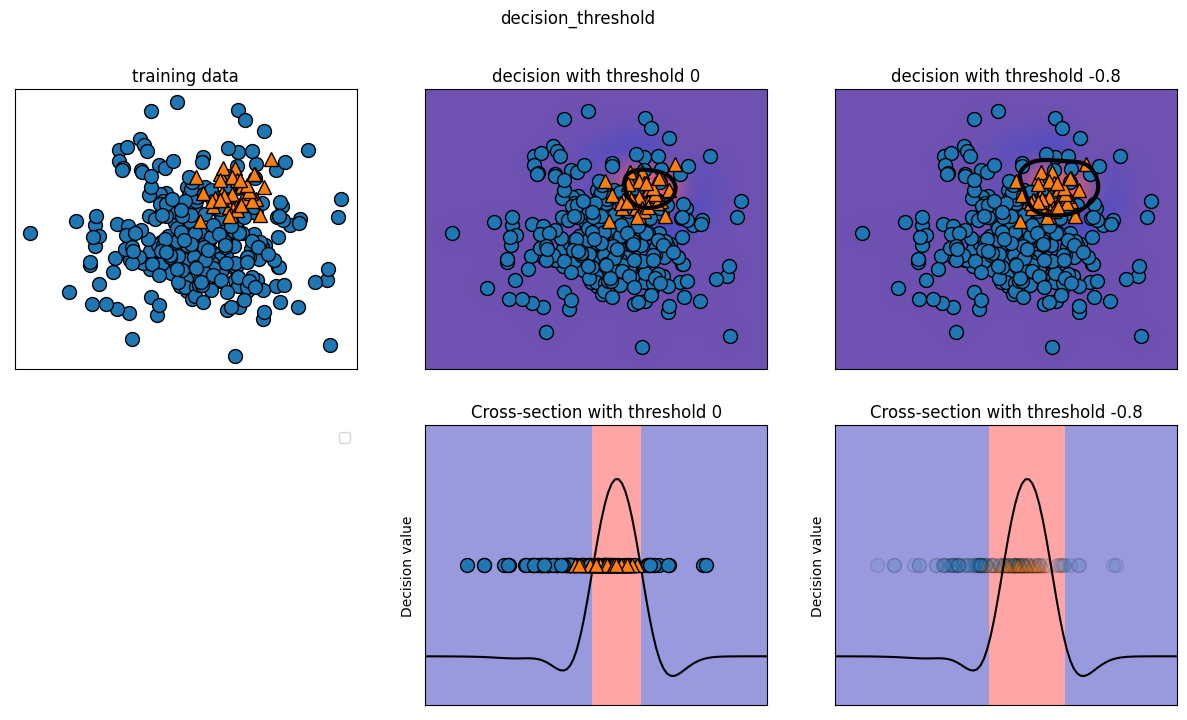

In [118]:
from helpers.plot_metrics import plot_decision_threshold

plot_decision_threshold()

# primer prikazuje kako izbor decision thresholda vpliva na našo metriko

In [119]:
print(classification_report(y_test, svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

    accuracy                           0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



In [120]:
y_pred_lower_threshold = svc.decision_function(X_test) > -.8

V našem primeru nam je bolj pomemben recall (npr. detekcija tumorjev), kar dosežemo s spreminjanjem thresholda.

In [121]:
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

    accuracy                           0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



nekateri modeli (npr. drevesa) imajo soroden parameter "predict_proba"

### Precision-recall curves
- posplošeno zgoraj -> testiramo različne thresholde, da vidimo kdaj dobimo najvišji precision/recall
- [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#:~:text=The%20precision%2Drecall%20curve%20shows,a%20low%20false%20negative%20rate.)

In [122]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

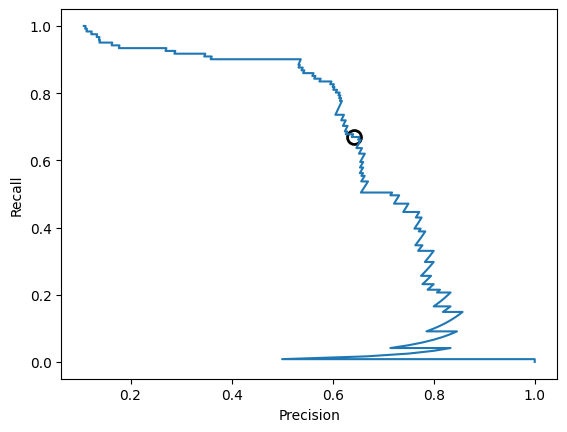

In [123]:
# Use more data points for a smoother curve
X, y = make_blobs(n_samples=(4000, 500), cluster_std=[7.0, 2], random_state=22)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

# krožec prikazuje okolico kjer je threshold 0
# optimalna točke je okoli cca recall 0.9, precision 0.56

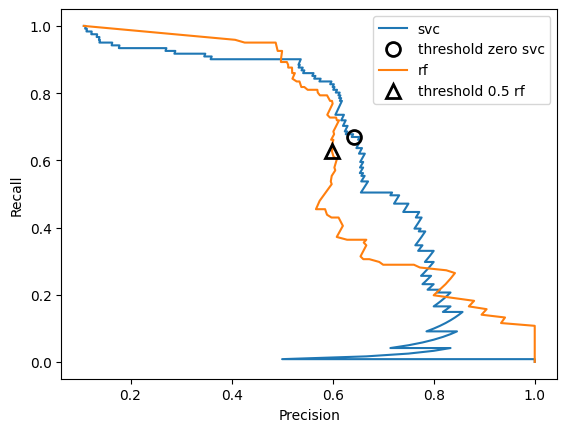

In [124]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=2)
rf.fit(X_train, y_train)

# RandomForestClassifier has predict_proba, but not decision_function
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label="svc")
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,label="threshold zero svc", fillstyle="none", c='k', mew=2)
plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k', markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")
plt.show()

# vidimo da random forest (rf) bolje dela v nekih ekstremih (visoki recali ali visoki precisioni)
# svc se bolje odreže v sredini

In [125]:
print(f"f1_score of random forest: {f1_score(y_test, rf.predict(X_test)):.3f}")
print(f"f1_score of svc: {f1_score(y_test, svc.predict(X_test)):.3f}")
# iz grafa zgoraj dobimo več podatkov o omenjenih področjih kje se kateri model bolje odreže

f1_score of random forest: 0.610
f1_score of svc: 0.656


- average precision score računa površino pod precision-recall krivuljo

In [126]:
from sklearn.metrics import average_precision_score

ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:, 1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))

print(f"Average precision of random forest: {ap_rf:.3f}")
print(f"Average precision of svc: {ap_svc:.3f}")

Average precision of random forest: 0.660
Average precision of svc: 0.666


### Receiver operating characteristics (ROC) and AUC
- The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR): [link](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
- primeri ko želimo visok recall in majhen false positive rate


    FPR = FP / (FP+TN)

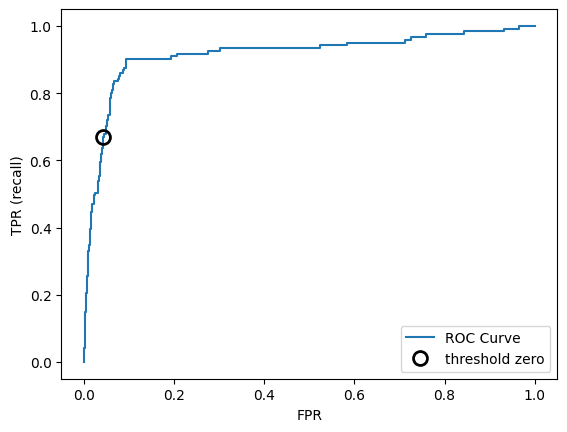

In [127]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show()

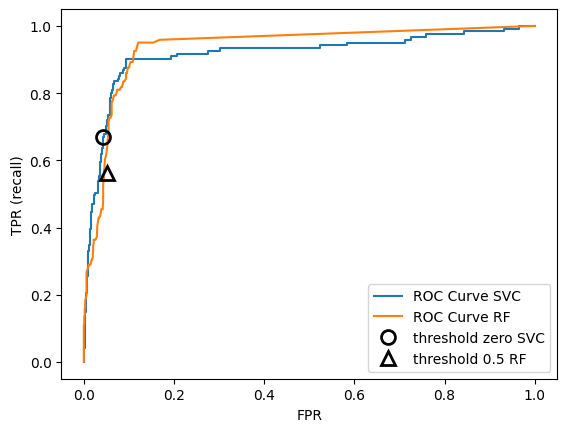

In [128]:
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve SVC")
plt.plot(fpr_rf, tpr_rf, label="ROC Curve RF")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label="threshold zero SVC", fillstyle="none", c='k', mew=2)

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))

plt.plot(fpr_rf[close_default_rf], tpr[close_default_rf], '^', markersize=10, label="threshold 0.5 RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)
plt.show()

In [129]:
from sklearn.metrics import roc_auc_score

rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))

print(f"AUC for Random Forest: {rf_auc:.3f}")
print(f"AUC for SVC: {svc_auc:.3f}")

AUC for Random Forest: 0.937
AUC for SVC: 0.916


gamma = 1.00 accuracy = 0.90 AUC = 0.50
gamma = 0.05 accuracy = 0.90 AUC = 1.00
gamma = 0.01 accuracy = 0.90 AUC = 1.00


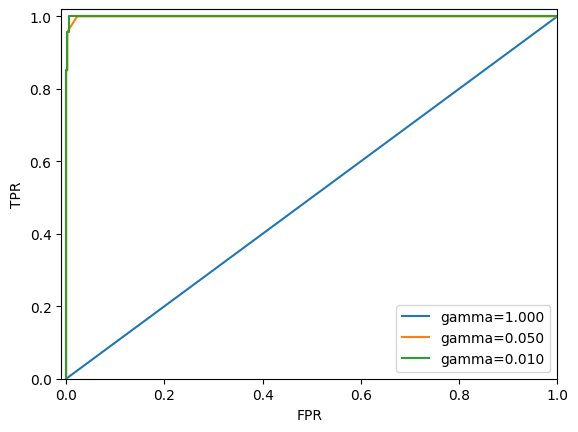

In [130]:
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=0)

plt.figure()

for gamma in [1, 0.05, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test , svc.decision_function(X_test))
    print(f"gamma = {gamma:.2f} accuracy = {accuracy:.2f} AUC = {auc:.2f}")
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")
plt.show()

**RocCurveDisplay function**

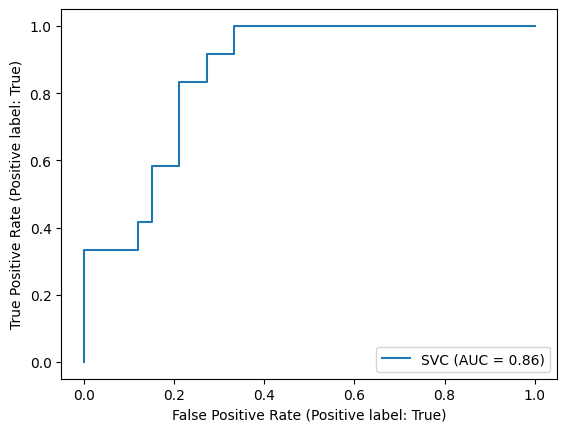

In [131]:
# plot a ROC curve for a fitted support vector machine
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay # novo v zadnji verziji sklearna za risanje ROC krivulje
from sklearn.datasets import load_wine

X, y = load_wine(return_X_y=True)
y = y == 2  # make binary
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
svc = SVC(random_state=42)
svc.fit(X_train, y_train)

svc_disp = RocCurveDisplay.from_estimator(svc, X_test, y_test)

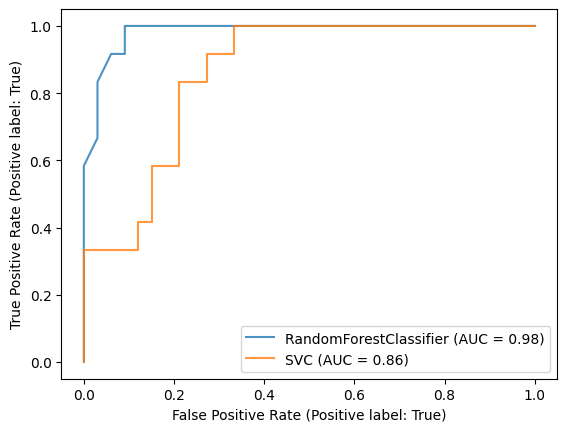

In [132]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(X_train, y_train)

ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## Metrics for Multiclass Classification

In [133]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)

lr = LogisticRegression(max_iter=10000, solver="liblinear").fit(X_train, y_train)
pred = lr.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, pred):.3f}")
print(f"Confusion matrix:\n{confusion_matrix(y_test, pred)}")

Accuracy: 0.953
Confusion matrix:
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


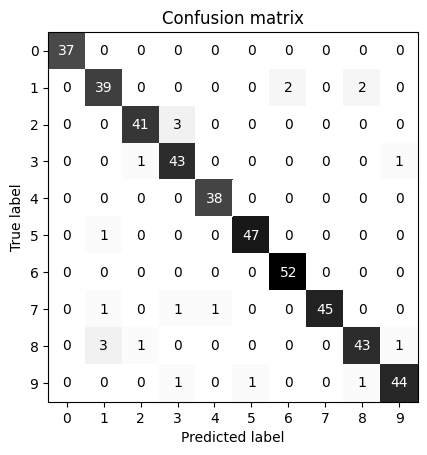

In [134]:
from helpers.tools import heatmap

scores_image = heatmap(confusion_matrix(y_test, pred), 
                       xlabel='Predicted label', 
                       ylabel='True label', 
                       xticklabels=digits.target_names, 
                       yticklabels=digits.target_names, 
                       cmap=plt.cm.gray_r, 
                       fmt="%d")

plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [135]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



In [136]:
print(f"Micro average f1 score: {f1_score(y_test, pred, average='micro'):.3f}")
print(f"Macro average f1 score: {f1_score(y_test, pred, average='macro'):.3f}")

Micro average f1 score: 0.953
Macro average f1 score: 0.954



The most important values for the scoring parameter for **classification** are:
- Balanced dataset
    - accuracy (the default);
- Unbalanced dataset
    - `roc_auc` for the area under the ROC curve; 
    - `average_precision` for the area under the precision-recall curve; 
    - `f1`, `f1_macro`, `f1_micro`, and `f1_weighted` for the binary f1-score and the different weighted variants. 

## Regression Metrics


For **regression**, the most commonly used values are:
- r2 for the R2 score, 
- `mean_squared_error` for mean squared error (MSE) -> poudari napake outlierjev
- `mean_absolute_error` for mean absolute error (MAE)
    - opcija tudi relativen error: mean absolute percentage error (MAPE)
    
You can find a full list of supported arguments in the documentation:
https://scikit-learn.org/stable/modules/model_evaluation.html

## Validation curve
- prikaz vgrajenih metod risanja validacijskih krivulj (v začetku tečaja smo to počeli ročno, glej nazaj)

In [137]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

X, y = load_digits(return_X_y=True)

subset_mask = np.isin(y, [1, 2])  # binary classification: 1 vs 2

X, y = X[subset_mask], y[subset_mask]

In [138]:
param_range = np.logspace(-6, -1, 5)

# use the default 5-fold cross validation,
train_scores, test_scores = validation_curve(
    SVC(),
    X,
    y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

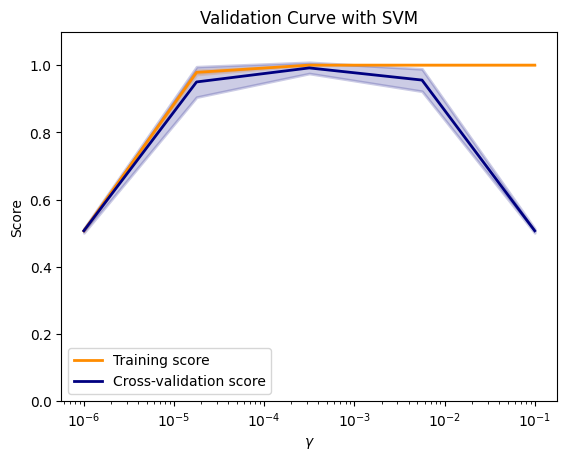

In [139]:
plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

## Learning curve
- kako se score odraža glede na število podatkov
- indikator ali bo število novih podatkov drastično izboljšalo učenje našega modela

In [140]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

train_sizes, train_scores, valid_scores = learning_curve(
    SVC(kernel='linear'), X, y, train_sizes=[50, 80, 110], cv=5)

train_sizes

array([ 50,  80, 110])

In [141]:
train_scores

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [142]:
valid_scores

array([[0.95833333, 0.90277778, 0.80555556, 0.95833333, 0.94366197],
       [0.97222222, 0.93055556, 0.90277778, 0.98611111, 0.97183099],
       [1.        , 0.98611111, 0.98611111, 1.        , 0.94366197]])

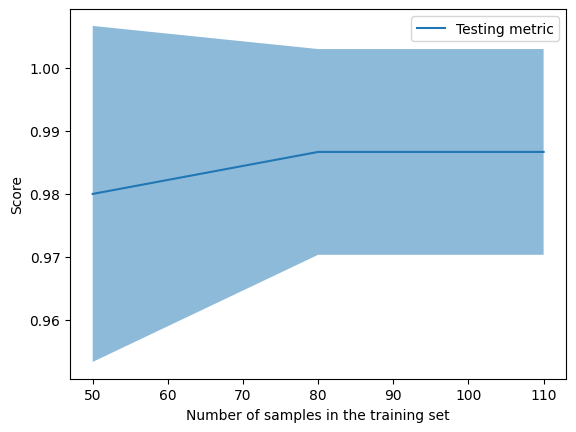

In [143]:
from sklearn.datasets import load_iris
from sklearn.model_selection import LearningCurveDisplay
from sklearn.svm import SVC
from sklearn.utils import shuffle

X, y = load_iris(return_X_y=True)
X, y = shuffle(X, y, random_state=0)

LearningCurveDisplay.from_estimator(
   SVC(kernel="linear"), X, y, train_sizes=[50, 80, 110], cv=5)
plt.show()

In [144]:
from sklearn.datasets import load_digits
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

X, y = load_digits(return_X_y=True)
naive_bayes = GaussianNB()
svc = SVC(kernel="rbf", gamma=0.001)

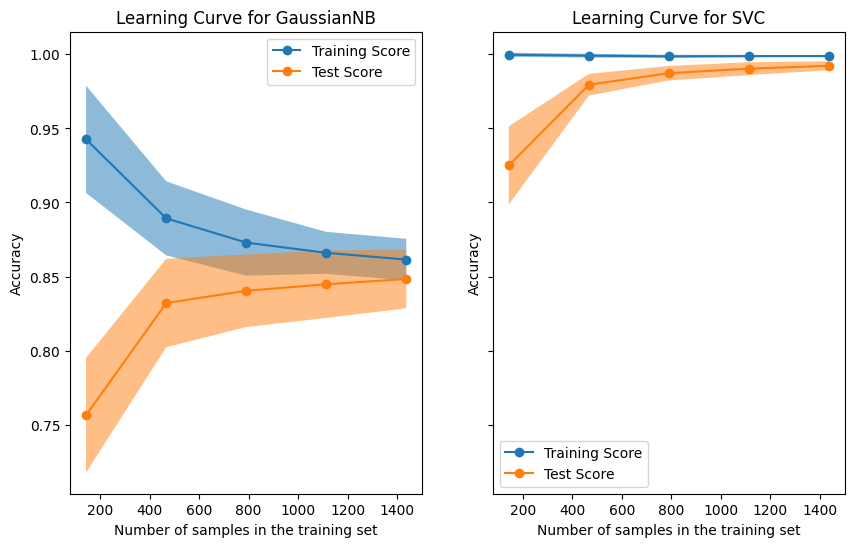

In [145]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([naive_bayes, svc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

## Metrics and scoring in sklearn

https://scikit-learn.org/stable/modules/model_evaluation.html

## Example: Classification Metrics
- case study zgornjih metrik na praktičnem primeru

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

X,Y  = datasets.load_breast_cancer(return_X_y=True)

print('Dataset Size : ',X.shape,Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    train_size=0.80, test_size=0.20,
                                                    stratify=Y,
                                                    random_state=1)


scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('Train/Test Size : ', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

log_reg = LogisticRegression(random_state=123)

log_reg.fit(X_train, Y_train)

Dataset Size :  (569, 30) (569,)
Train/Test Size :  (455, 30) (114, 30) (455,) (114,)


LogisticRegression(random_state=123)

In [147]:
Y_preds = log_reg.predict(X_test)

In [148]:
from sklearn.metrics import accuracy_score

print(Y_preds[:15])
print(Y_test[:15])

print('Test Accuracy     : {:.3f}'.format(accuracy_score(Y_test, Y_preds)))
print('Test Accuracy     : {:.3f}'.format(log_reg.score(X_test, Y_test))) ## Score method also evaluates accuracy for classification models.
print('Training Accuracy : {:.3f}'.format(log_reg.score(X_train, Y_train)))

[1 0 1 1 0 1 1 1 0 1 0 1 1 0 1]
[1 0 1 1 0 1 1 1 0 1 0 1 1 0 1]
Test Accuracy     : 0.974
Test Accuracy     : 0.974
Training Accuracy : 0.969


In [149]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_test, Y_preds)
print(conf_mat)

[[39  3]
 [ 0 72]]


In [150]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

print('Precision                                   : %.3f'%precision_score(Y_test, Y_preds))
print('Recall                                      : %.3f'%recall_score(Y_test, Y_preds))
print('F1-Score                                    : %.3f'%f1_score(Y_test, Y_preds))

Precision                                   : 0.960
Recall                                      : 1.000
F1-Score                                    : 0.980


In [151]:
print('\nPrecision Recall F1-Score Support Per Class : \n',precision_recall_fscore_support(Y_test, Y_preds))


Precision Recall F1-Score Support Per Class : 
 (array([1.  , 0.96]), array([0.92857143, 1.        ]), array([0.96296296, 0.97959184]), array([42, 72], dtype=int64))


In [152]:
print('\nClassification Report : ')
print(classification_report(Y_test, Y_preds))


Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        42
           1       0.96      1.00      0.98        72

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [153]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(Y_test, log_reg.decision_function(X_test))

auc = roc_auc_score(Y_test, log_reg.decision_function(X_test))

acc = log_reg.score(X_test, Y_test)

print("False Positive Rates : {}".format(fpr))
print("True  Positive Rates : {}".format(tpr))
print("Threshols            : {}".format(thresholds))
print("Accuracy             : {:.3f}".format(acc))
print("AUC                  : {:.3f}".format(auc))

False Positive Rates : [0.         0.         0.         0.02380952 0.02380952 1.        ]
True  Positive Rates : [0.         0.01388889 0.88888889 0.88888889 1.         1.        ]
Threshols            : [ 7.69569607  6.69569607  1.73588264  1.62377044  0.28791722 -9.60220554]
Accuracy             : 0.974
AUC                  : 0.997


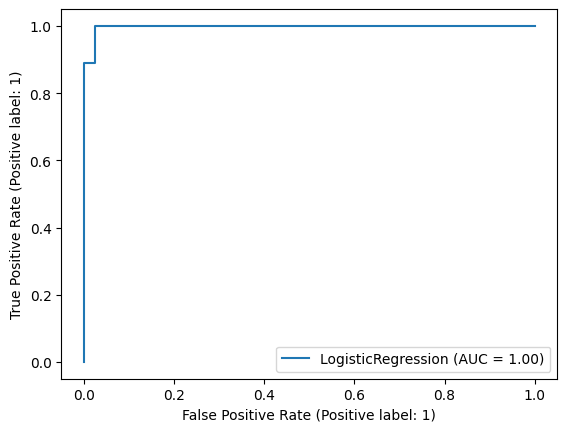

In [154]:
svc_disp = RocCurveDisplay.from_estimator(log_reg, X_test, Y_test)

In [155]:
from sklearn.metrics import precision_recall_curve, auc,average_precision_score

#precision, recall, thresholds = precision_recall_curve(Y_test, log_reg.predict_proba(X_test)[:,1])
precision, recall, thresholds = precision_recall_curve(Y_test, log_reg.decision_function(X_test))

acc = log_reg.score(X_test, Y_test)

p_auc = auc(recall, precision)

print("Accuracy  : {:.3f}".format(acc))
print("AUC       : {:.3f}".format(p_auc))

Accuracy  : 0.974
AUC       : 0.998


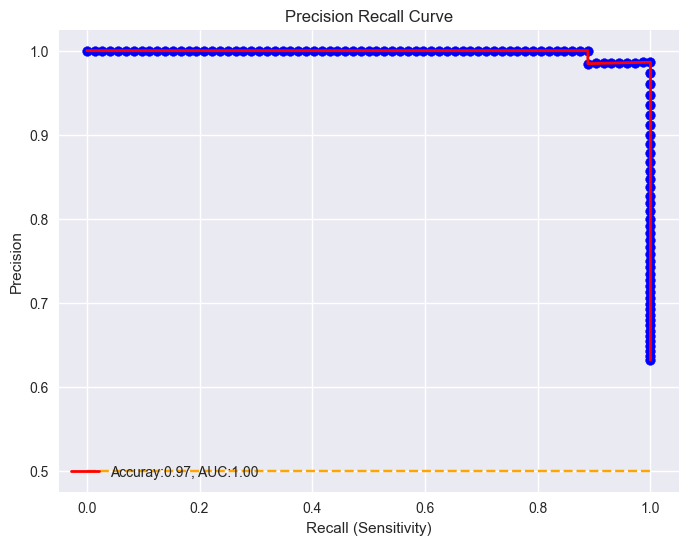

In [156]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(recall, precision, c='blue')
    plt.plot(recall, precision, label="Accuray:%.2f, AUC:%.2f" % (acc, p_auc), linewidth=2, c='red')
    plt.hlines(0.5,0.0,1.0, linestyle='dashed', colors=['orange'])
    plt.xlabel("Recall (Sensitivity)")
    plt.ylabel("Precision")
    plt.title('Precision Recall Curve')
    plt.legend(loc='best');
    plt.show()

## Using Evaluation Metrics in Model Selection
- cross validation v sklearnu ima parameter "scoring", ki omogoča da spremenimo default scoring
- to vpliva na postopek hiperoptimizacije in končni rezultat optimalnih hiperparametrov

In [157]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

digits = load_digits()

# default scoring for classification is accuracy
print(f"Default scoring: {cross_val_score(SVC(), digits.data, digits.target == 9, cv=3)}")

# providing scoring="accuracy" doesn't change the results
explicit_accuracy = cross_val_score(SVC(), digits.data, digits.target == 9, scoring="accuracy", cv=3)
print(f"Explicit accuracy scoring: {explicit_accuracy}")

roc_auc = cross_val_score(SVC(), digits.data, digits.target == 9, scoring="roc_auc", cv=3)
print(f"AUC scoring: {roc_auc}")

Default scoring: [0.97996661 0.98664441 0.98330551]
Explicit accuracy scoring: [0.97996661 0.98664441 0.98330551]
AUC scoring: [0.99557823 0.99879406 0.98964131]


In [158]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target == 9, random_state=0)

# we provide a somewhat bad grid to illustrate the point:
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}

# using the default scoring of accuracy:
grid = GridSearchCV(SVC(), param_grid=param_grid)

grid.fit(X_train, y_train)
print("Grid-Search with accuracy")
print("Best parameters:", grid.best_params_)
print(f"Best cross-validation score (accuracy)): {grid.best_score_:.3f}")
print(f"Test set AUC: {roc_auc_score(y_test, grid.decision_function(X_test)):.3f}")
print(f"Test set accuracy: {grid.score(X_test, y_test):.3f}")

Grid-Search with accuracy
Best parameters: {'gamma': 0.0001}
Best cross-validation score (accuracy)): 0.976
Test set AUC: 0.992
Test set accuracy: 0.973


In [159]:
# using AUC scoring instead:
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring="roc_auc")
grid.fit(X_train, y_train)
print("\nGrid-Search with AUC")
print("Best parameters:", grid.best_params_)
print(f"Best cross-validation score (AUC): {grid.best_score_:.3f}")
print(f"Test set AUC: {roc_auc_score(y_test, grid.decision_function(X_test)):.3f}")
print(f"Test set accuracy: {grid.score(X_test, y_test):.3f}")


Grid-Search with AUC
Best parameters: {'gamma': 0.01}
Best cross-validation score (AUC): 0.998
Test set AUC: 1.000
Test set accuracy: 1.000
